<a href="https://colab.research.google.com/github/ipavlopoulos/revisiting-silhouette-aggregation/blob/main/revisiting_silhouette_aggregation_synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Sihouette Coefficient
* Using micro and macro averaging.
* Using two sampling strategies, one per aggregation type.

In [117]:
from sklearn.metrics import silhouette_samples
import pandas as pd
import numpy as np

import numpy as np
np.random.seed=42

def control_sample(X, clustering, balanced=False, sample_size=-1):
    """
    Sample data points from the dataset based on the specified strategy.

    This function samples data points based on the sample strategy:
    - 'uniform': Randomly samples 'sample_size' number of rows from the entire dataset.
    - 'balanced': Samples a specified number of rows per cluster.

    Parameters:
    X (array-like): 2D array-like structure with the coordinates of the data points.
    clustering (array-like): Cluster labels for the data points.
    balanced (bool): If True, samples a specified number of rows per cluster.
                     If False, samples 'sample_size' number of rows uniformly from the entire dataset.
    sample_size (int): Total number of samples to draw. If sample_size is less than 1, the entire dataset is returned.

    Returns:
    tuple: Two arrays, one with the sampled data points and another with the corresponding cluster labels.
    """
    if sample_size < 1:
        return X, clustering

    X = np.array(X)
    clustering = np.array(clustering)

    if not balanced:
        indices = np.random.choice(len(X), size=sample_size, replace=False)
        return X[indices], clustering[indices]

    # Otherwise: sample n rows per cluster
    unique_clusters, counts = np.unique(clustering, return_counts=True)
    samples_per_cluster = max(1, sample_size // len(unique_clusters))

    sampled_X = []
    sampled_clustering = []

    for cluster in unique_clusters:
        cluster_indices = np.where(clustering == cluster)[0]
        sample_indices = np.random.choice(cluster_indices, size=min(len(cluster_indices), samples_per_cluster), replace=False)
        sampled_X.append(X[sample_indices])
        sampled_clustering.append(clustering[sample_indices])

    sampled_X = np.vstack(sampled_X)
    sampled_clustering = np.hstack(sampled_clustering)

    return sampled_X, sampled_clustering


class SampleSilhouette:

  def __init__(self, X, clustering, sample_size=-1, sample_strategy='micro'):
    self.X, self.clustering = control_sample(X, clustering, balanced=sample_strategy=='macro', sample_size=sample_size)
    self.point_sil = pd.DataFrame({'sil': silhouette_samples(self.X, self.clustering), 'label':self.clustering})


  def macro(self):
    """
    Macro-averaged silhouette, for per-cluster averaging, then returning their mean
    :return: the silhouette aggregated score
    """
    representatives = self.point_sil.groupby('label').sil.apply(np.mean)
    return representatives.mean()

  def micro(self):
    """
    Micro-averaged silhouette, as in sklearn
    :return: the silhouette aggregated score
    """
    return self.point_sil.sil.mean()

# Assessing KMeans using micro/macro-averaged Silhouette

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def generate_spiral_clusters_varying_points(n_clusters, base_points_per_cluster, base_variance, points_growth_factor):
    t = np.linspace(0, 4 * np.pi, n_clusters)
    x = t * np.cos(t)
    y = t * np.sin(t)

    X = []
    y_labels = []
    cluster_sizes = []
    for i in range(n_clusters):
        cx, cy = x[i], y[i]
        variance = base_variance
        # Number of points increasing with a growth factor
        points_per_cluster = int(base_points_per_cluster * np.exp(points_growth_factor * (n_clusters - i)))
        cluster_points = np.random.normal(loc=[cx, cy], scale=variance, size=(points_per_cluster, 2))
        X.append(cluster_points)
        y_labels.append(np.full(points_per_cluster, i))
        cluster_sizes.append(points_per_cluster)

    X = np.vstack(X)
    y_labels = np.hstack(y_labels)

    return X, y_labels, x, y, cluster_sizes

# Parameters for the dataset
n_clusters = 20
base_points_per_cluster = 10
base_variance = 0.1  # Same variance for all clusters

# Highest points growth factor to create the most imbalanced space
points_growth_factor = 0.3

# Generate the spiral clusters dataset
X, y_labels, x, y, cluster_sizes = generate_spiral_clusters_varying_points(n_clusters, base_points_per_cluster, base_variance, points_growth_factor)

# Run K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(X)
kmeans_labels = kmeans.labels_

# Compute the Silhouette Score
score = silhouette_score(X, kmeans_labels)
print(f'Silhouette Score for the most imbalanced space: {score}')

Silhouette Score for the most imbalanced space: 0.812348071798607


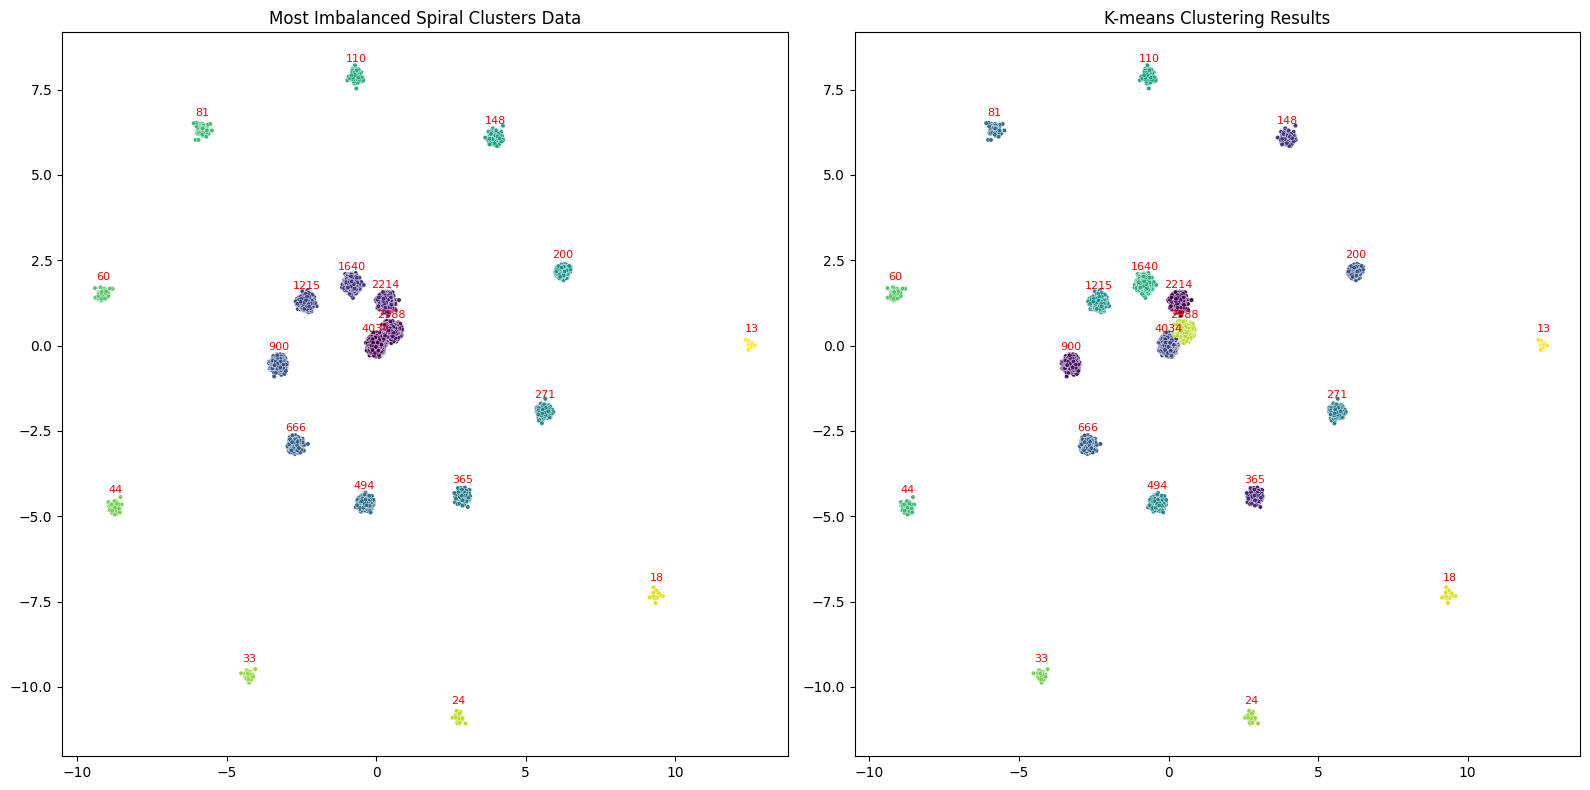

In [63]:
import seaborn as sns

# Plot the original dataset with true labels and annotations
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_labels, palette='viridis', s=10, legend=None)
plt.title("Most Imbalanced Spiral Clusters Data")
for i, (cx, cy) in enumerate(zip(x, y)):
    plt.annotate(str(cluster_sizes[i]), (cx, cy), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

# Plot the K-means clustering results
plt.subplot(1, 2, 2)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=kmeans_labels, palette='viridis', s=10, legend=None)
plt.title("K-means Clustering Results")
for i, (cx, cy) in enumerate(zip(x, y)):
    plt.annotate(str(cluster_sizes[i]), (cx, cy), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.tight_layout()
plt.show()

In [56]:
# Range of points growth factors to test
points_growth_factors = np.linspace(0.1, 0.3, 10)
macro_scores, micro_scores = [], []
for points_growth_factor in points_growth_factors:
    # Generate the spiral clusters dataset
    X, y_labels, x, y, cluster_sizes = generate_spiral_clusters_varying_points(n_clusters, base_points_per_cluster, base_variance, points_growth_factor)

    # Run K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X)
    kmeans_labels = kmeans.labels_

    # Compute the Silhouette Score
    ssilhouette = SampleSilhouette(X, kmeans_labels)
    macro_scores.append(ssilhouette.macro())
    micro_scores.append(ssilhouette.micro())

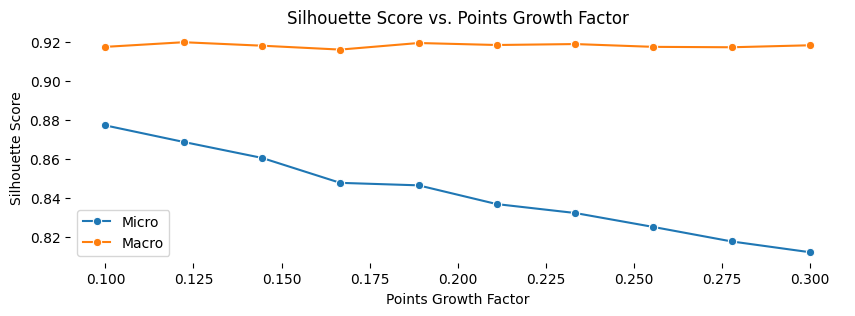

In [56]:
plt.figure(figsize=(10, 3))
sns.lineplot(x=points_growth_factors, y=micro_scores, marker='o', label='Micro')
sns.lineplot(x=points_growth_factors, y=macro_scores, marker='o', label='Macro')
plt.legend()
plt.xlabel('Points Growth Factor')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Points Growth Factor')
sns.despine(left=True, bottom=True)

# Sampled and Averaged Silhouette

In [104]:
# Range of points growth factors to test
points_growth_factors = np.linspace(0.1, 0.3, 10)
macro_sils, micro_sils = [], []
for points_growth_factor in points_growth_factors:
    # Generate the spiral clusters dataset
    X, y_labels, x, y, cluster_sizes = generate_spiral_clusters_varying_points(n_clusters, base_points_per_cluster, base_variance, points_growth_factor)

    # Run K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X)
    kmeans_labels = kmeans.labels_

    # Compute the Silhouette Score
    macro_sils.append(SampleSilhouette(X, kmeans_labels, sample_size=100, sample_strategy='macro'))
    micro_sils.append(SampleSilhouette(X, kmeans_labels, sample_size=100, sample_strategy='micro'))

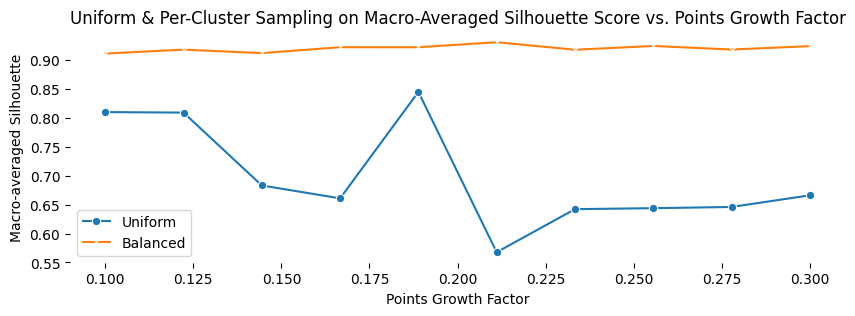

In [107]:
plt.figure(figsize=(10, 3))
sns.lineplot(x=points_growth_factors, y=[s.macro() for s in micro_sils], marker='o', label='Uniform')
sns.lineplot(x=points_growth_factors, y=[s.macro() for s in macro_sils], marker='x', label='Balanced')
plt.legend()
plt.xlabel('Points Growth Factor')
plt.ylabel('Macro-averaged Silhouette')
plt.title('Uniform & Per-Cluster Sampling on Macro-Averaged Silhouette Score vs. Points Growth Factor')
sns.despine(left=True, bottom=True)

# Focusing on noise
* First, monitoring the macro and micro averaged Silhouette score as noise is added to a space of Gaussians.

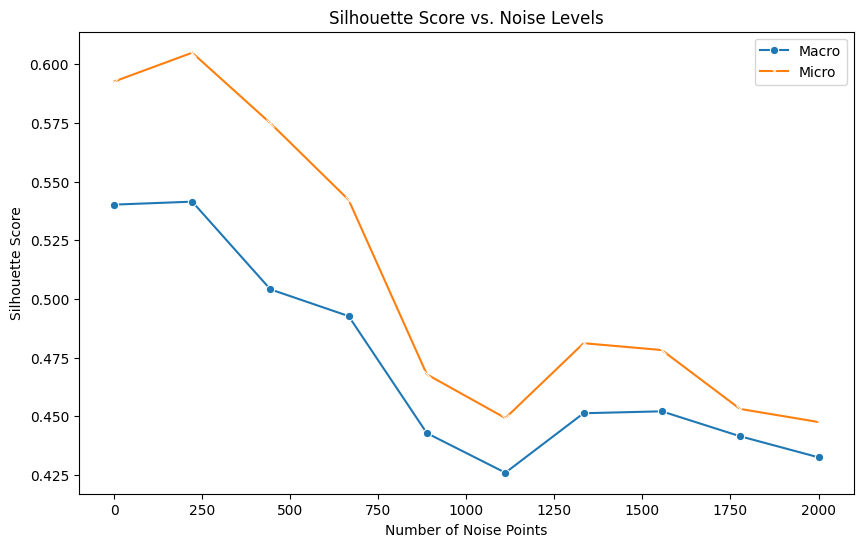

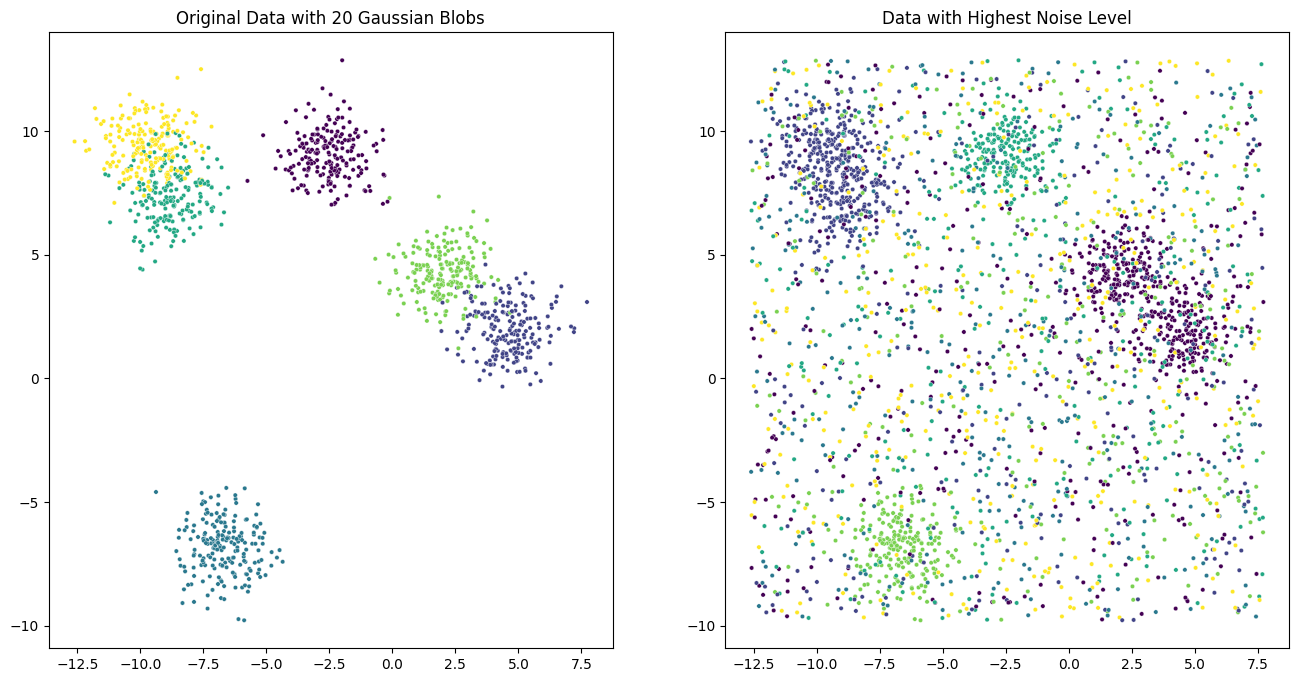

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def add_noise(X, n_noise_points):
    """
    Add random noise points to the dataset.

    Parameters:
    X (array-like): Original dataset.
    n_noise_points (int): Number of noise points to add.

    Returns:
    array-like: Dataset with added noise points.
    """
    noise = np.random.uniform(low=X.min(axis=0), high=X.max(axis=0), size=(n_noise_points, 2))
    return np.vstack([X, noise])

# Generate the original dataset with 20 Gaussian blobs
n_clusters = 6
points_per_cluster = 200
X, y_labels = make_blobs(n_samples=n_clusters * points_per_cluster, centers=n_clusters, cluster_std=1.0, random_state=42)

# Range of noise levels to test
noise_levels = np.linspace(0, 2000, 10, dtype=int)
silhouette_scores_macro, silhouette_scores_micro = [], []

for n_noise_points in noise_levels:
    X_noisy = add_noise(X, n_noise_points)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X_noisy)
    kmeans_labels = kmeans.labels_

    # Compute the Silhouette Score
    sil = SampleSilhouette(X_noisy, kmeans_labels)
    silhouette_scores_macro.append(sil.macro())
    silhouette_scores_micro.append(sil.micro())

# Plot the Silhouette Scores for different noise levels using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=noise_levels, y=silhouette_scores_macro, marker='o', label='Macro')
sns.lineplot(x=noise_levels, y=silhouette_scores_micro, marker='x', label='Micro')
plt.xlabel('Number of Noise Points')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Noise Levels')
plt.show()

# Plot the original dataset and one example with the highest noise level
plt.figure(figsize=(16, 8))

# Original dataset
plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_labels, palette='viridis', s=10, legend=None)
plt.title("Original Data with 20 Gaussian Blobs")

# Dataset with the highest noise level
X_noisy = add_noise(X, noise_levels[-1])
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_noisy[:, 0], y=X_noisy[:, 1], hue=kmeans_labels, palette='viridis', s=10, legend=None)
plt.title("Data with Highest Noise Level")
plt.show()

* Now, the task changes to approximating the number of clusters, by varying K and computing Silhouette per noise level; per averaging strategy.

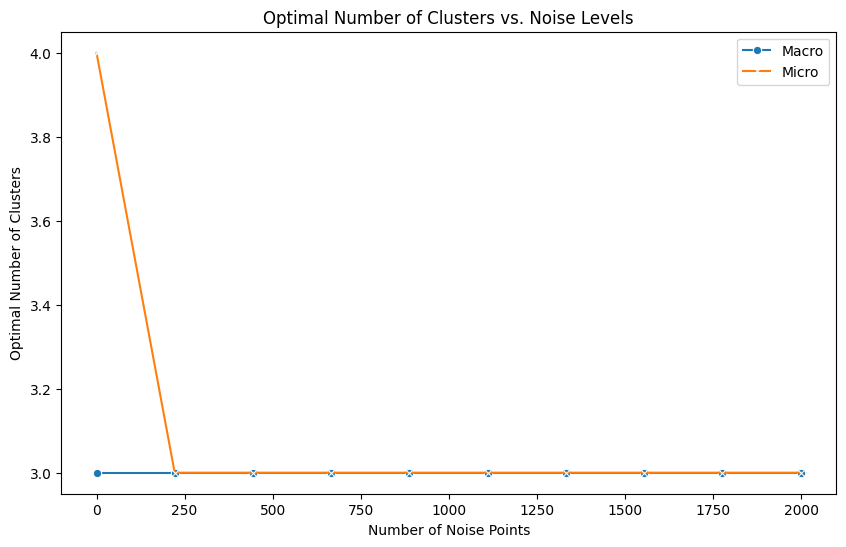

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


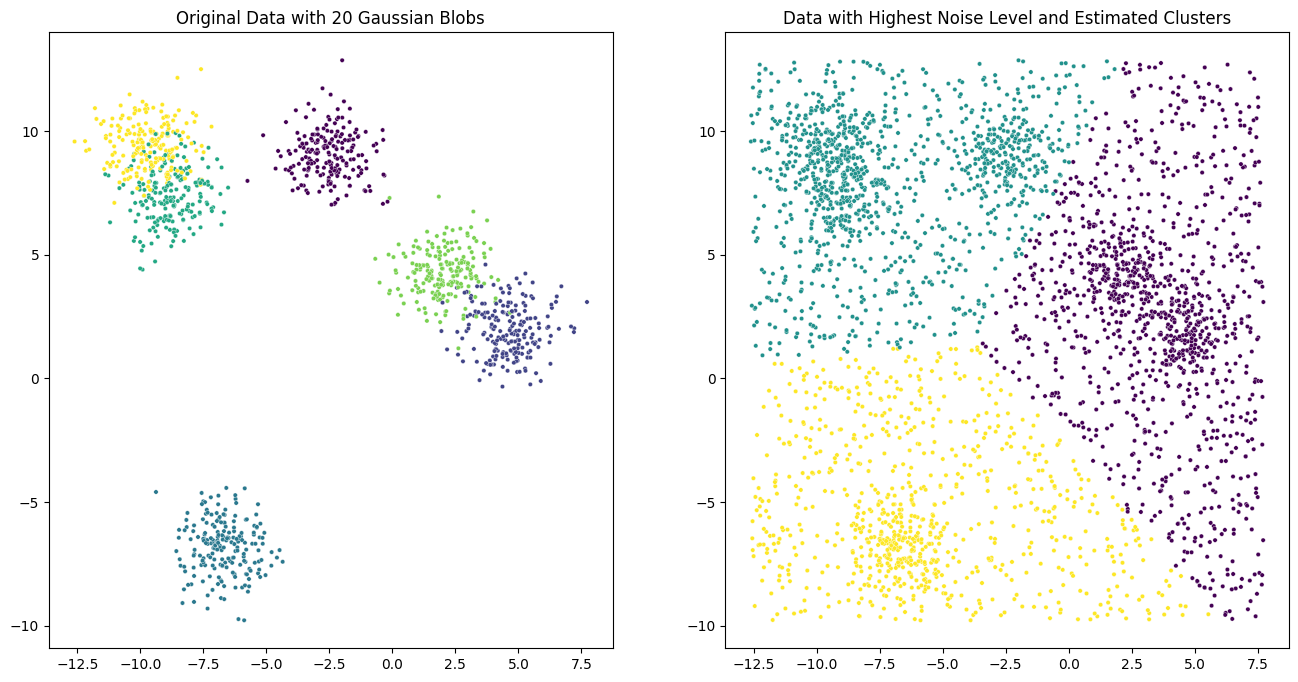

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Range of noise levels to test
noise_levels = np.linspace(0, 2000, 10, dtype=int)

# Range of number of clusters to test
cluster_range = range(3, 10)
optimal_clusters_per_noise_macro = []
optimal_clusters_per_noise_micro = []

for n_noise_points in noise_levels:
    X_noisy = add_noise(X, n_noise_points)

    best_score_micro, best_score_macro = -1, -1
    best_n_clusters_micro, best_n_clusters_macro = 0, 0
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        kmeans.fit(X_noisy)
        kmeans_labels = kmeans.labels_
        ssil = SampleSilhouette(X_noisy, kmeans_labels)
        macrosil = ssil.macro()
        microsil = ssil.micro()

        if  macrosil > best_score_macro:
            best_score_macro = macrosil
            best_n_clusters_macro = n_clusters
        if  microsil > best_score_micro:
            best_score_micro = microsil
            best_n_clusters_micro = n_clusters

    optimal_clusters_per_noise_macro.append(best_n_clusters_macro)
    optimal_clusters_per_noise_micro.append(best_n_clusters_micro)

# Plot the number of clusters detected per noise level
plt.figure(figsize=(10, 6))
sns.lineplot(x=noise_levels, y=optimal_clusters_per_noise_macro, marker='o', label='Macro')
sns.lineplot(x=noise_levels, y=optimal_clusters_per_noise_micro, marker='x', label='Micro')
plt.xlabel('Number of Noise Points')
plt.ylabel('Optimal Number of Clusters')
plt.title('Optimal Number of Clusters vs. Noise Levels')
plt.show()

# Plot the original dataset and one example with the highest noise level
plt.figure(figsize=(16, 8))

# Original dataset
plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_labels, palette='viridis', s=10, legend=None)
plt.title("Original Data with 20 Gaussian Blobs")

# Dataset with the highest noise level
X_noisy = add_noise(X, noise_levels[-1])
kmeans = KMeans(n_clusters=optimal_clusters_per_noise_micro[-1], random_state=42)
kmeans.fit(X_noisy)
kmeans_labels = kmeans.labels_

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_noisy[:, 0], y=X_noisy[:, 1], hue=kmeans_labels, palette='viridis', s=10, legend=None)
plt.title("Data with Highest Noise Level and Estimated Clusters")

plt.show()
